## Fitting Limit Cycles



In [138]:
import numpy as np
import functorch

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch_vector_field import utilities, plotting, vector_field

We generate paired observations of $(x, \dot x)$ for a few different dynamical systems. See ```generate_data.py``` for details.

In [139]:
xs = np.load('data/simple_rot_field_x.npy')
dot_xs = np.load('data/simple_rot_field_dx.npy')

full_ds = torch.utils.data.TensorDataset(
    torch.from_numpy(xs.astype(np.float32)), 
    torch.from_numpy(dot_xs.astype(np.float32))
)
train_len = int(xs.shape[0] * 0.8)
test_len = xs.shape[0] - train_len

train_ds, test_ds = torch.utils.data.random_split(full_ds, [train_len, test_len])

train_loader = torch.utils.data.DataLoader(train_ds, batch_size = 128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size= 128, shuffle=True)

Let's visualize the dynamical system. 

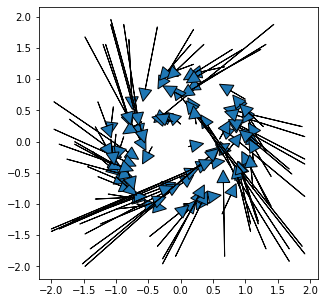

In [140]:
idx = np.random.choice(np.arange(xs.shape[0]), size=100)
plotting.plot_dyn_sys_data(xs[idx], dot_xs[idx])

### Defining the Potential Field

Now we need to define the parametrization of the vector field. 

To start with, this is just a slightly relaxed version of the original formulation. Concretely, we introduce $\theta$-dependent nonnegative coefficients into the equation $h_\theta = a_\theta r^2 + b_\theta \exp(-r^2)$. $a_\theta, b_\theta$ are parametrized by neural nets. 


In [141]:
def radial_coordinate_transform(x):
    """
    x is a tensor of shape [...,2] describing 2D coordinates
    Return a tensor of shape [...,1] (radius) and [...,2] (unit vector)
    """
    r = torch.linalg.norm(x, dim=-1, keepdim=True)
    x_unit = x / r
    return r, x_unit

class SimplePotentialField(nn.Module):
    def __init__(self):
        super(SimplePotentialField, self).__init__()
        self.a = nn.Sequential(
            nn.Linear(2, 8),
            nn.ELU(),
            nn.Linear(8,1)
        )
        self.b = nn.Sequential(
            nn.Linear(2, 8),
            nn.ELU(),
            nn.Linear(8,1)
        )

    def forward(self, x):
        r, x_unit = radial_coordinate_transform(x)
        # Ensure r**2 coeff is nonnegative
        rsq_coeff = F.elu(self.a(x_unit)) + 1
        # Ensure exp coeff is positive
        rexp_coeff = F.elu(self.b(x_unit)) + 2
        return rsq_coeff * r ** 2 \
            + rexp_coeff * torch.exp(-r**2)


Let's visualize the unoptimized potential field. 

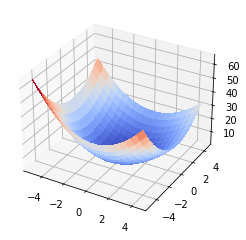

In [142]:
potential_field = SimplePotentialField()
p_field_wrapped = vector_field.TorchToNumpyPotentialFieldWrapper(potential_field)
plotting.plot_potential_field(p_field_wrapped, np.array([-5, 5]), np.array([-5, 5]), step_size = 0.5, max_clip = 1000, min_clip=-1000)

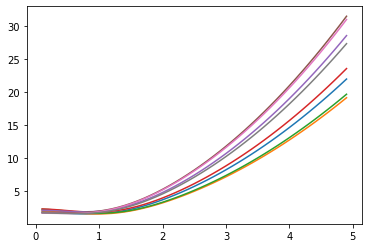

In [143]:
plotting.plot_sections(
    p_field_wrapped, 
    rs = np.arange(0, 5, step=0.1), 
    thetas=np.arange(8) * np.pi / 4
)

Not bad. Even without optimization, the potential field already has the desired 'bowl' shape along rays from 0 while still being smooth over the full state space (by construction). 

### Defining the Rotational Field


In [144]:
class SimpleRotationalField(nn.Module):
    def __init__(self):
        super(SimpleRotationalField, self).__init__()
        self.r = nn.Sequential(
            nn.Linear(2, 8),
            nn.ELU(),
            nn.Linear(8,1)
        )

    def forward(self, x):
        # Make magnitude nonnegative
        magnitude = F.elu(self.r(x)) + 1
        _, x_unit = radial_coordinate_transform(x)
        
        x1_unit, x2_unit = x_unit[...,0].unsqueeze(-1), x_unit[...,1].unsqueeze(-1)
        v_unit = torch.cat([-x2_unit, x1_unit], dim=-1)
        return magnitude * v_unit

Again, let's see what the unoptimized version looks like. 

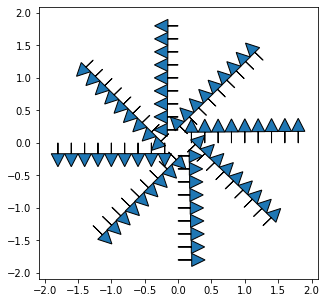

In [145]:
rotational_field = SimpleRotationalField()
r_field_wrapped = vector_field.TorchToNumpyVectorFieldWrapper(rotational_field)

def get_circle_points(rs: np.ndarray, thetas: np.ndarray):
    points = []
    for r in rs:
        for theta in thetas:
            points.append(np.array([r * np.cos(theta), r * np.sin(theta)]))
    return points

circle_points = get_circle_points(
    rs = np.arange(0,2,0.2),
    thetas = np.arange(8) * np.pi / 4
)

plotting.plot_vectors(
    r_field_wrapped, circle_points
)

So far so good.

### Combining the Two Fields

We define a utility class for getting the gradient of an NN instead of the value.

Note this will only work for scalar-valued NNs. 

In [146]:
class GradientWrapper(nn.Module):
    """ Wraps a scalar-valued nn.Module to get the gradient instead of the value """
    def __init__(self, net: nn.Module, positive: bool = True):
        super(GradientWrapper, self).__init__()
        self.net = net
        self.sign = 1 if positive else -1
        net_fn, net_params, net_buffer = functorch.make_functional_with_buffers(net)

        def net_forward_fn(x):
            """ x is assumed not to have the batch dimension """ 
            out = net_fn(net_params, net_buffer, x)
            out = out.squeeze()
            return out

        self.grad_net_fn = functorch.grad(net_forward_fn)
        # vmap lets us spread the application of grad_fn to each sample in the batch
        self.batched_grad_net_fn = functorch.vmap(functorch.grad(net_forward_fn))

    def forward(self, x):
        if len(x.shape) == 1:
            print("Batch dimension not found; applying unbatched gradient")
            return self.grad_net_fn(x) * self.sign
        elif len(x.shape) >= 2:
            return self.batched_grad_net_fn(x) * self.sign
        else:
            raise Exception(f"Invalid tensor of shape {x.shape} passed")


class LinearCombinationWrapper(nn.Module):
    """Linearly combine two nn Modules"""
    def __init__(self, v1, v2, a1 = 0.5, a2 = 0.5):
        super(LinearCombinationWrapper, self).__init__()
        self.v1 = v1
        self.v2 = v2 
        self.a1 = a1
        self.a2 = a2 

    def forward(self, x):
        return self.a1 * self.v1(x) + self.a2 * self.v2(x)

Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dime

/home/dtch1997/anaconda3/envs/learning_limit_cycles/lib/python3.9/site-packages/matplotlib/patches.py:1444: RuntimeWarning: invalid value encountered in double_scalars
  cx = self._dx / distance
/home/dtch1997/anaconda3/envs/learning_limit_cycles/lib/python3.9/site-packages/matplotlib/patches.py:1445: RuntimeWarning: invalid value encountered in double_scalars
  sx = self._dy / distance


Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dime

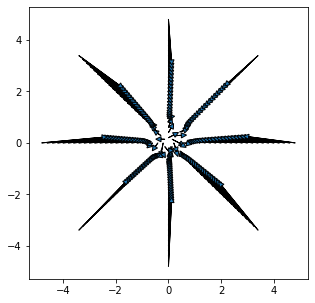

In [147]:
g = GradientWrapper(potential_field, positive=False)
g_field_wrapped = vector_field.TorchToNumpyVectorFieldWrapper(g)

circle_points = get_circle_points(
    rs = np.arange(0,5,0.2),
    thetas = np.arange(8) * np.pi / 4
)

plotting.plot_vectors(g_field_wrapped, circle_points)

Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dime

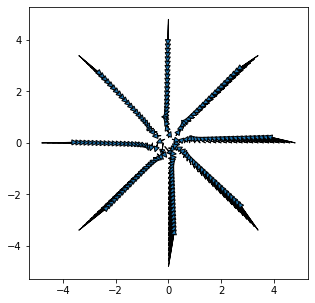

In [148]:
combined_field = LinearCombinationWrapper(
    GradientWrapper(potential_field, positive=False),
    rotational_field
)
c_field_wrapped = vector_field.TorchToNumpyVectorFieldWrapper(combined_field)

plotting.plot_vectors(
    c_field_wrapped, circle_points
)

We define some utilities for training and testing the model on the systems ID task

In [149]:
def train(
    net: nn.Module, 
    train_loader: torch.utils.data.DataLoader,  
    learning_rate = 1e-3,  
    momentum=0.9,
    n_epochs = 10,
):
    criterion = nn.HuberLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)

    for epoch in range(n_epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimizes
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 10 == 9:    # print every 10 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 10:.3f}')
                running_loss = 0.0

    print('Finished Training')
    return net

def eval(net, test_ds):
    with torch.no_grad():
        features, targets = test_ds[:]
        preds_np = net(features).detach().cpu().numpy()
        targets_np = targets.detach().cpu().numpy()
        return preds_np, targets_np

In [150]:
def build_baseline_net():
    return nn.Sequential(
        nn.Linear(2, 8),
        nn.ELU(),
        nn.Linear(8, 2)
    )

In [151]:
baseline_net = train(build_baseline_net(), train_loader, n_epochs=200)

[1,    10] loss: 2.462
[1,    20] loss: 2.452
[1,    30] loss: 2.368
[1,    40] loss: 2.375
[1,    50] loss: 2.363
[1,    60] loss: 2.182
[2,    10] loss: 2.238
[2,    20] loss: 2.230
[2,    30] loss: 2.122
[2,    40] loss: 2.129
[2,    50] loss: 2.073
[2,    60] loss: 2.110
[3,    10] loss: 1.942
[3,    20] loss: 1.912
[3,    30] loss: 2.067
[3,    40] loss: 1.990
[3,    50] loss: 1.998
[3,    60] loss: 1.895
[4,    10] loss: 1.930
[4,    20] loss: 1.893
[4,    30] loss: 1.885
[4,    40] loss: 1.758
[4,    50] loss: 1.753
[4,    60] loss: 1.779
[5,    10] loss: 1.776
[5,    20] loss: 1.753
[5,    30] loss: 1.662
[5,    40] loss: 1.736
[5,    50] loss: 1.762
[5,    60] loss: 1.657
[6,    10] loss: 1.602
[6,    20] loss: 1.640
[6,    30] loss: 1.740
[6,    40] loss: 1.516
[6,    50] loss: 1.615
[6,    60] loss: 1.617
[7,    10] loss: 1.566
[7,    20] loss: 1.596
[7,    30] loss: 1.529
[7,    40] loss: 1.620
[7,    50] loss: 1.525
[7,    60] loss: 1.431
[8,    10] loss: 1.484
[8,    20] 

In [152]:
net = train(combined_field, train_loader, n_epochs = 200, learning_rate=1e-5)

[1,    10] loss: 36185984206.034
[1,    20] loss: 1.434
[1,    30] loss: 1.382
[1,    40] loss: 1.380
[1,    50] loss: 1.408
[1,    60] loss: 1.480
[2,    10] loss: 36185984206.117
[2,    20] loss: 1.371
[2,    30] loss: 1.365
[2,    40] loss: 1.353
[2,    50] loss: 1.408
[2,    60] loss: 1.478
[3,    10] loss: 1.361
[3,    20] loss: 1.378
[3,    30] loss: 36185984206.110
[3,    40] loss: 1.363
[3,    50] loss: 1.350
[3,    60] loss: 1.558
[4,    10] loss: 1.312
[4,    20] loss: 1.334
[4,    30] loss: 36185984206.060
[4,    40] loss: 1.411
[4,    50] loss: 1.519
[4,    60] loss: 1.411
[5,    10] loss: 1.380
[5,    20] loss: 1.422
[5,    30] loss: 1.436
[5,    40] loss: 1.406
[5,    50] loss: 1.413
[5,    60] loss: 36185984206.053
[6,    10] loss: 1.440
[6,    20] loss: 1.448
[6,    30] loss: 1.379
[6,    40] loss: 36185984206.053
[6,    50] loss: 1.441
[6,    60] loss: 1.398
[7,    10] loss: 36185984206.085
[7,    20] loss: 1.436
[7,    30] loss: 1.356
[7,    40] loss: 1.474
[7,    50]

In [153]:
preds, targets = eval(net, test_ds)

In [158]:
learned_field_wrapped = vector_field.TorchToNumpyVectorFieldWrapper(net)
baseline_field_wrapped = vector_field.TorchToNumpyVectorFieldWrapper(baseline_net)

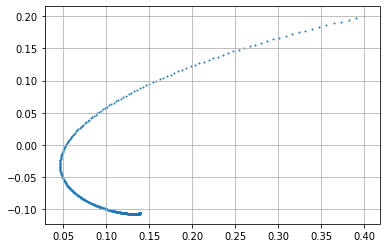

In [169]:
history = utilities.simulate_trajectory(
    baseline_field_wrapped, 
    np.array([0.4, 0.2]), 
    num_iters=1000,
    grad_clip=0.1,
    ascending=True
)
plotting.plot_histories([history])

Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dime

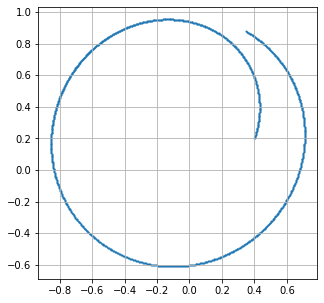

In [168]:
history = utilities.simulate_trajectory(
    learned_field_wrapped, 
    np.array([0.4, 0.2]), 
    num_iters=1000,
    ascending=True,
    grad_clip=0.1
)
plotting.plot_histories([history], figsize=(5,5))

Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dime

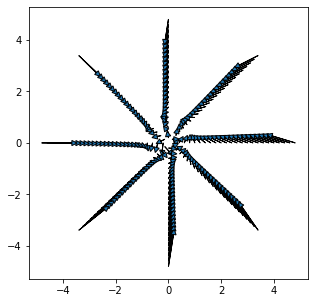

In [156]:
plotting.plot_vectors(
    learned_field_wrapped, circle_points
)